# Gradient Considerations
<!-- ---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
--- -->

In [86]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [ ]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [ ]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [ ]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS

In [ ]:
# !cat configs/postprocess.yaml

In [ ]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream.

In [ ]:
%%time

# load config
config_dm = OmegaConf.load("./configs/postprocess.yaml")

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_FULL).compute()
ds_natl60

CPU times: user 12.9 s, sys: 2.96 s, total: 15.9 s
Wall time: 45.1 s


<xarray.Dataset>
Dimensions:  (time: 42, lat: 600, lon: 600)
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.6549 0.6571 0.6593 ... -0.2152 -0.2174
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [8]:
nadir4_config = OmegaConf.load(f"./configs/natl60_obs.yaml")
ds_nadir4 = hydra.utils.instantiate(nadir4_config.ALONGTRACK_NADIR4.data).compute()
ds_swot1nadir5 = hydra.utils.instantiate(
    nadir4_config.ALONGTRACK_SWOT1NADIR5.data
).compute()
ds_swot1nadir5

<xarray.Dataset>
Dimensions:  (time: 1003548)
Coordinates:
    lon      (time) float64 -55.03 -55.06 -55.1 -55.13 ... -59.01 -59.03 -59.05
    lat      (time) float64 39.58 39.53 39.47 39.42 ... 42.81 42.87 42.93 42.98
  * time     (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12-02T...
Data variables:
    ssh      (time) float64 0.9958 1.014 1.027 1.032 ... -0.112 -0.1122 -0.1118
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

## Regrdding: AlongTrack -> Uniform Grid

In [9]:
from oceanbench._src.geoprocessing.gridding import (
    grid_to_regular_grid,
    coord_based_to_grid,
)

In [10]:
%%time

ds_nadir4 = coord_based_to_grid(
    coord_based_ds=ds_nadir4,
    target_grid_ds=ds_natl60.pint.dequantify(),
)
ds_swot1nadir5 = coord_based_to_grid(
    coord_based_ds=ds_swot1nadir5,
    target_grid_ds=ds_natl60.pint.dequantify(),
)

CPU times: user 3.6 s, sys: 211 ms, total: 3.81 s
Wall time: 3.82 s


#### AlongTrack -> Uniform Grid

In [11]:
# load config
psd_config = OmegaConf.load("./configs/metrics.yaml")

ds_natl60 = hydra.utils.instantiate(psd_config.fill_nans)(ds_natl60.pint.dequantify())

In [12]:
def correct_labels(ds):
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ssh"].attrs["units"] = "m"
    ds["ssh"].attrs["standard_name"] = "sea_surface_height"
    ds["ssh"].attrs["long_name"] = "Sea Surface Height"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"

    return ds

In [13]:
def plot_obs(ds, variable: str = "ssh", **kwargs):
    fig, ax = plt.subplots(figsize=(7, 5.5))

    X, Y = np.meshgrid(ds[variable].lon, ds[variable].lat, indexing="ij")

    xlabel = f"{ds.lon.attrs['long_name']} [{ds.lon.attrs['units']}]"
    ylabel = f"{ds.lat.attrs['long_name']} [{ds.lat.attrs['units']}]"

    pts = ax.scatter(
        X,
        Y,
        c=np.ma.masked_invalid(ds[variable]).T,
        marker="s",
        s=0.25,
        vmin=kwargs.pop("vmin", None),
        vmax=kwargs.pop("vmax", None),
    )
    ax.set(
        xlim=kwargs.pop("xlim", None),
        ylim=kwargs.pop("ylim", None),
        xlabel=xlabel,
        ylabel=ylabel,
    )
    name = ds[variable].attrs["long_name"]
    unit = ds[variable].attrs["units"]
    label = f"{name} [{unit}]"
    plt.colorbar(pts, cmap=kwargs.pop("cmap", "viridis"), label=label)

    ax.set_title(pd.to_datetime(ds.time.values).strftime("%Y-%m-%d"))
    fig.tight_layout()

    return fig, ax

In [14]:
vmin, vmax = (
    correct_labels(ds_natl60).ssh.min().pint.dequantify(),
    correct_labels(ds_natl60).ssh.max().pint.dequantify(),
)
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]
itime = "2012-10-27"
variable = "ssh"

# SWOT1NADIR5
fig, ax = plot_obs(
    correct_labels(ds_swot1nadir5).sel(time=itime).pint.dequantify(),
    variable,
    vmin=vmin,
    vmax=vmax,
    xlim=xlim,
    ylim=ylim,
    cmap="viridis",
)
fig.savefig(f"./figures/dc20a/maps/dc20a_ssh_swot1nadir5_{itime}.png")
plt.close()
# NADIR4
fig, ax = plot_obs(
    correct_labels(ds_nadir4).sel(time=itime).pint.dequantify(),
    variable,
    vmin=vmin,
    vmax=vmax,
    xlim=xlim,
    ylim=ylim,
    cmap="viridis",
)
fig.savefig(f"./figures/dc20a/maps/dc20a_ssh_nadir4_{itime}.png")
plt.close()

## Coarsend Versions

In [15]:
ds_natl60 = ds_natl60.coarsen({"lon": 3, "lat": 3}).mean()
ds_natl60

<xarray.Dataset>
Dimensions:  (time: 42, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.97 -64.92 -64.87 -64.82 ... -55.12 -55.07 -55.02
  * lat      (lat) float64 33.03 33.08 33.13 33.18 ... 42.83 42.88 42.93 42.98
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.652 0.6585 0.6642 ... -0.2079 -0.2149
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

### Prediction Datasets 

In [16]:
%%time

# load config

experiment = "swot" # "nadir" # 
if experiment == "nadir":
    # load config
    results_config = OmegaConf.load(f"./configs/results_dc20a_nadir.yaml")

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(
        results_config.NERF_SIREN_NADIR.data
    ).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()
elif experiment == "swot":
    # load config
    results_config = OmegaConf.load(f"./configs/results_dc20a_swot.yaml")

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_SWOT.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_SWOT.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(
        results_config.NERF_SIREN_SWOT.data
    ).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_SWOT.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_SWOT.data).compute()

CPU times: user 188 ms, sys: 52.7 ms, total: 241 ms
Wall time: 568 ms


In [17]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/

nadir1.nc  nadir4.nc  nadir5.nc  swot1nadir5.nc  swot1.nc  swot.nc


## Regrdding

#### Uniform Grid --> Uniform Grid

In [18]:
%%time

ds_duacs = grid_to_regular_grid(
    src_grid_ds=ds_duacs.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)
ds_miost = grid_to_regular_grid(
    src_grid_ds=ds_miost.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)
ds_nerf_siren = grid_to_regular_grid(
    src_grid_ds=ds_nerf_siren.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)
ds_nerf_ffn = grid_to_regular_grid(
    src_grid_ds=ds_nerf_ffn.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)
ds_nerf_mlp = grid_to_regular_grid(
    src_grid_ds=ds_nerf_mlp.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)

CPU times: user 12 s, sys: 161 ms, total: 12.2 s
Wall time: 12.2 s


### Preprocess Chain

In [19]:
%%time

# load config
psd_config = OmegaConf.load("./configs/metrics.yaml")

ds_duacs = hydra.utils.instantiate(psd_config.fill_nans)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.fill_nans)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.fill_nans)(
    ds_nerf_siren.pint.dequantify()
)
ds_nerf_ffn = hydra.utils.instantiate(psd_config.fill_nans)(
    ds_nerf_ffn.pint.dequantify()
)
ds_nerf_mlp = hydra.utils.instantiate(psd_config.fill_nans)(
    ds_nerf_mlp.pint.dequantify()
)

CPU times: user 971 ms, sys: 0 ns, total: 971 ms
Wall time: 974 ms


## Physical Variables

In [20]:
from oceanbench._src.geoprocessing import geostrophic as geocalc
from metpy.units import units

In [21]:
def calculate_anomaly(ds, variable="ssh", dim=["lat", "lon"]):
    ds[f"{variable}_anomaly"] = ds[variable] - ds[variable].mean(dim=dim)
    return ds

In [62]:
def calculate_physical_quantities(da):
    # da = da.pint.quantify(
    #     {
    #         "ssh": "meter",
    #         "lon": "degrees_east",
    #         "lat": "degrees_north",
    #         "time": "seconds",
    #     }
    # )
    da["ssh"] *= units.meters
    da["lon"] = da.lon * units.degrees
    da["lat"] = da.lat * units.degrees
    da = calculate_anomaly(da, variable="ssh", dim=["lat", "lon"])
    da = geocalc.streamfunction(da, "ssh")
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "div")
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "vort_r")
    da = geocalc.strain_magnitude(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [63]:
ds_natl60 = calculate_physical_quantities(ds_natl60.pint.dequantify())
ds_natl60

<xarray.Dataset>
Dimensions:      (time: 42, lat: 200, lon: 200)
Coordinates:
  * lon          (lon) float64 -64.97 -64.92 -64.87 ... -55.12 -55.07 -55.02
  * lat          (lat) float64 33.03 33.08 33.13 33.18 ... 42.88 42.93 42.98
  * time         (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh          (time, lat, lon) float32 [m] 0.6520022 ... -0.21487716
    ssh_anomaly  (time, lat, lon) float32 [m] 0.21967244 0.22621 ... -0.62783194
    psi          (time, lat, lon) float64 [m²/s] 7.129e+04 ... -2.349e+04
    u            (time, lat, lon) float64 [m/s] 0.3173 0.2937 ... 0.03065 0.034
    v            (time, lat, lon) float64 [m/s] 0.1632 0.1429 ... -0.1873
    ke           (time, lat, lon) float64 [m²/s²] 0.06364 0.05333 ... 0.01813
    div          (time, lat, lon) float64 [] 0.00134 0.001017 ... -0.002834
    vort_r       (time, lat, lon) float64 [] -4.076 -6.084 -7.36 ... 2.045 6.967
    strain       (time, lat, lon) float64 [] 5.962 6.215 6.596 ... 5.562 4.481
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [64]:
%%time

ds_natl60 = calculate_physical_quantities(ds_natl60.pint.dequantify())
ds_duacs = calculate_physical_quantities(ds_duacs.pint.dequantify())
ds_miost = calculate_physical_quantities(ds_miost.pint.dequantify())
ds_nerf_siren = calculate_physical_quantities(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = calculate_physical_quantities(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = calculate_physical_quantities(ds_nerf_mlp.pint.dequantify())

CPU times: user 3.47 s, sys: 218 ms, total: 3.69 s
Wall time: 3.7 s


## Sea Surface Height

In [103]:
def plot_map(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    vmin=kwargs.pop("vmin", None)
    vmax=kwargs.pop("vmax", None)
    cmap=kwargs.pop("cmap", "viridis")
    loc = ticker.MaxNLocator(kwargs.pop("levels", 5))
    
    ds[variable].plot.pcolormesh(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs=kwargs.pop("cbar_kwargs", None),
        **kwargs,
    )
    
    levels = loc.tick_values(ds[variable].min().values, ds[variable].max().values)
    ds[variable].plot.contour(
        ax=ax, 
        levels=levels,
        alpha=0.5, linewidths=1, cmap="black",
        # vmin=vmin, vmax=vmax,
        # **kwargs
    )    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax
from matplotlib import ticker

def plot_ssh_map(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    vmin=kwargs.pop("vmin", ds[variable].min().values)
    vmax=kwargs.pop("vmax", ds[variable].max().values)
    cmap=kwargs.pop("cmap", "viridis")
    levels = kwargs.pop("levels", 5)
    
    ds[variable].plot.pcolormesh(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs=kwargs.pop("cbar_kwargs", None),
        **kwargs,
    )
    loc = ticker.MaxNLocator(levels)
    levels = loc.tick_values(ds[variable].min().values, ds[variable].max().values)
    ds[variable].plot.contour(
        ax=ax, 
        alpha=0.5, linewidths=1, cmap="black",
        levels=levels,
        linestyles=np.where(levels >= 0, "-", "--")
        # vmin=vmin, vmax=vmax,
        # **kwargs
    )    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax

In [66]:
ds_natl60_mean = ds_natl60.mean(dim=["lat", "lon"])
ds_duacs_mean = ds_duacs.mean(dim=["lat", "lon"])
ds_miost_mean = ds_miost.mean(dim=["lat", "lon"])
ds_nerf_mlp_mean = ds_nerf_mlp.mean(dim=["lat", "lon"])
ds_nerf_ffn_mean = ds_nerf_ffn.mean(dim=["lat", "lon"])
ds_nerf_siren_mean = ds_nerf_siren.mean(dim=["lat", "lon"])

ds_natl60_var = ds_natl60.var(dim=["lat", "lon"])
ds_duacs_var = ds_duacs.var(dim=["lat", "lon"])
ds_miost_var = ds_miost.var(dim=["lat", "lon"])
ds_nerf_mlp_var = ds_nerf_mlp.var(dim=["lat", "lon"])
ds_nerf_ffn_var = ds_nerf_ffn.var(dim=["lat", "lon"])
ds_nerf_siren_var = ds_nerf_siren.var(dim=["lat", "lon"])

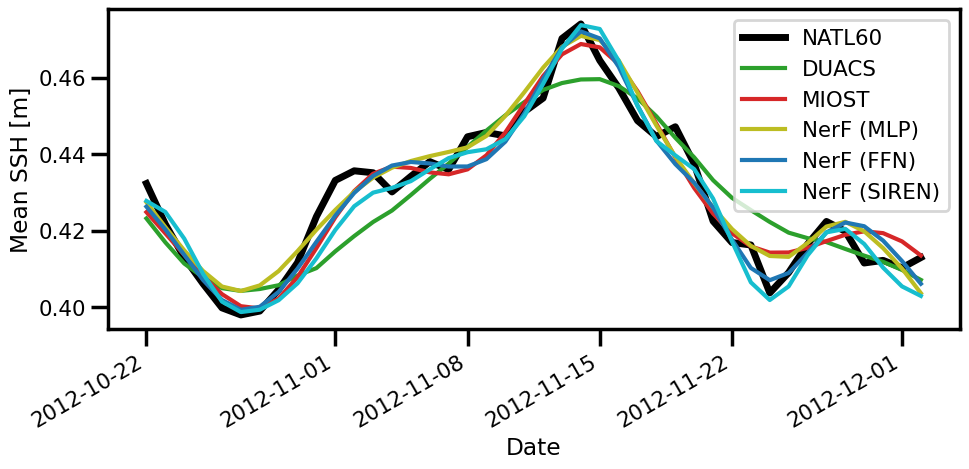

In [67]:
fig, ax = plt.subplots(figsize=(10,5))

ds_natl60_mean.ssh.plot(ax=ax, label="NATL60", color="black", linewidth=5)
ds_duacs_mean.ssh.plot(ax=ax, label="DUACS", color="tab:green")
ds_miost_mean.ssh.plot(ax=ax, label="MIOST", color="tab:red")
ds_nerf_mlp_mean.ssh.plot(ax=ax, label="NerF (MLP)", color="tab:olive")
ds_nerf_ffn_mean.ssh.plot(ax=ax, label="NerF (FFN)", color="tab:blue")
ds_nerf_siren_mean.ssh.plot(ax=ax, label="NerF (SIREN)", color="tab:cyan")
ax.set(
    xlabel="Date", 
    ylabel="Mean SSH [m]"
)

plt.legend()
plt.tight_layout()
plt.show()

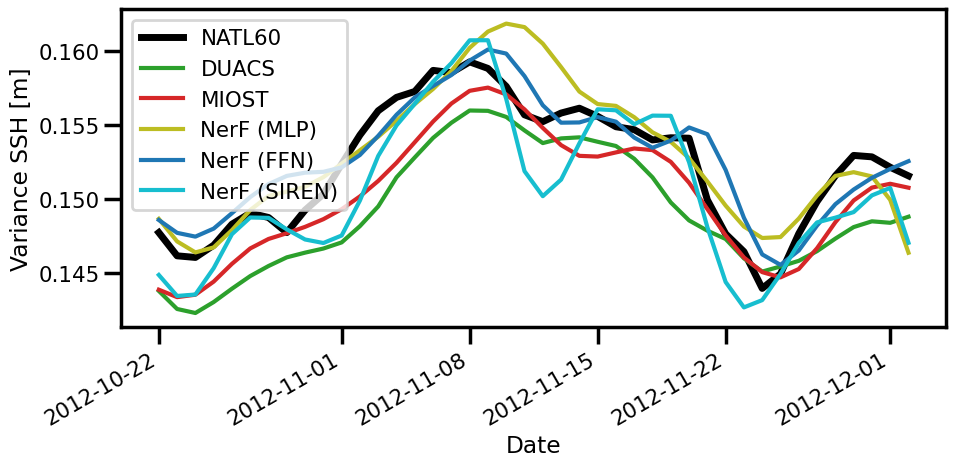

In [68]:
fig, ax = plt.subplots(figsize=(10,5))

ds_natl60_var.ssh.plot(ax=ax, label="NATL60", color="black", linewidth=5)
ds_duacs_var.ssh.plot(ax=ax, label="DUACS", color="tab:green")
ds_miost_var.ssh.plot(ax=ax, label="MIOST", color="tab:red")
ds_nerf_mlp_var.ssh.plot(ax=ax, label="NerF (MLP)", color="tab:olive")
ds_nerf_ffn_var.ssh.plot(ax=ax, label="NerF (FFN)", color="tab:blue")
ds_nerf_siren_var.ssh.plot(ax=ax, label="NerF (SIREN)", color="tab:cyan")
ax.set(
    xlabel="Date", 
    ylabel="Variance SSH [m]"
)

plt.legend()
plt.tight_layout()
plt.show()

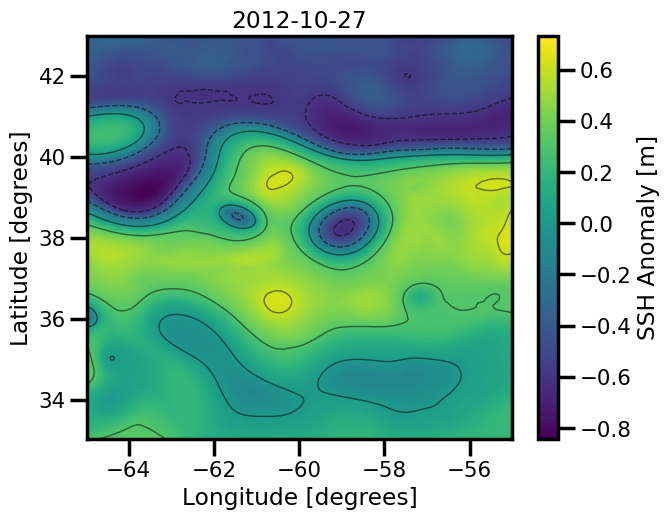

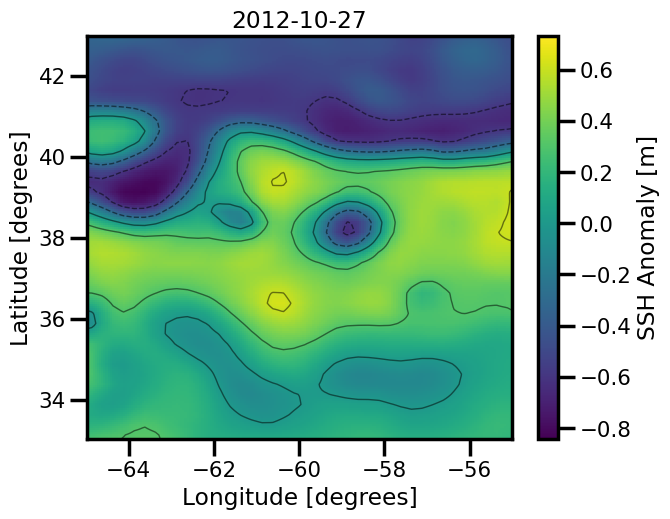

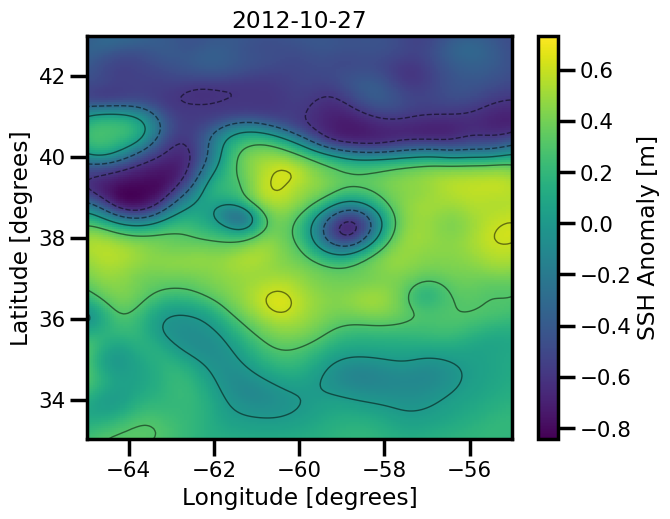

In [105]:
variable = "ssh_anomaly"
vmin = correct_labels(ds_natl60)[variable].min().pint.dequantify()
vmax = correct_labels(ds_natl60)[variable].max().pint.dequantify()
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]
itime = "2012-10-27"
cmap = "viridis"


#NATL60
fig, ax = plot_ssh_map(
    correct_labels(ds_natl60).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_natl60_{experiment}_{itime}.png")
plt.show()

# DUACS
fig, ax = plot_ssh_map(
    correct_labels(ds_duacs).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_duacs_{experiment}_{itime}.png")
plt.show()

# MIOST
fig, ax = plot_ssh_map(
    correct_labels(ds_miost).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_miost_{experiment}_{itime}.png")
plt.show()

# NERF - MLP
fig, ax = plot_ssh_map(
    correct_labels(ds_nerf_mlp).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_mlp_{experiment}_{itime}.png")
plt.close()

# NERF - FFN
fig, ax = plot_ssh_map(
    correct_labels(ds_nerf_ffn).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_ffn_{experiment}_{itime}.png")
plt.close()

# NERF - SIREN
fig, ax = plot_ssh_map(
    correct_labels(ds_nerf_siren).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_siren_{experiment}_{itime}.png")
plt.close()

## Kinetic Energy

In [70]:
def plot_ke_map(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    vmin=kwargs.pop("vmin", None)
    vmax=kwargs.pop("vmax", None)
    cmap=kwargs.pop("cmap", "viridis")
    # loc = ticker.MaxNLocator()
    loc = ticker.LogLocator(numticks=kwargs.pop("levels", 10))
    
    ds[variable].plot.pcolormesh(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs=kwargs.pop("cbar_kwargs", None),
        **kwargs,
    )
    
    levels = loc.tick_values(ds[variable].min().values, ds[variable].max().values)
    
    ds[variable].plot.contour(
        ax=ax, 
        levels=levels,
        alpha=0.5, linewidths=1, cmap="black",
        # vmin=vmin, vmax=vmax,
        # **kwargs
    )    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax

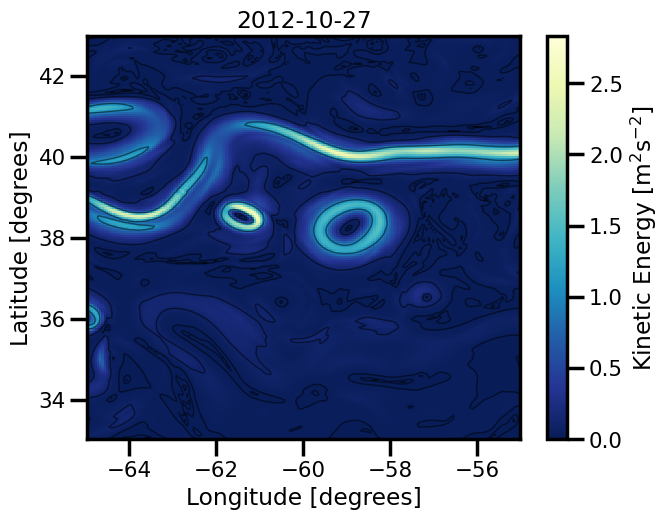

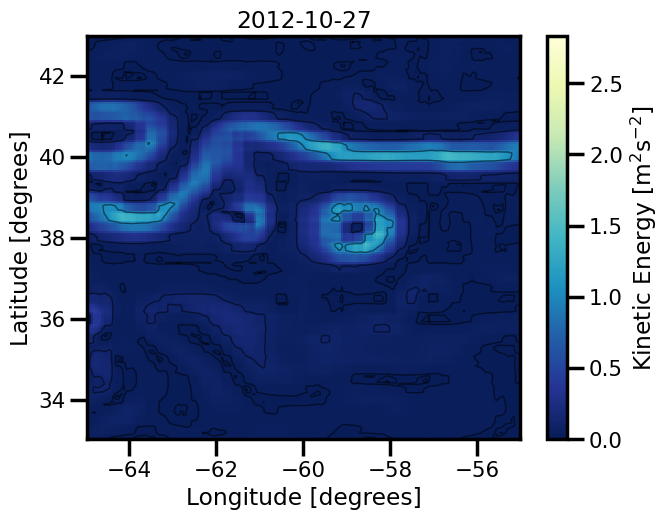

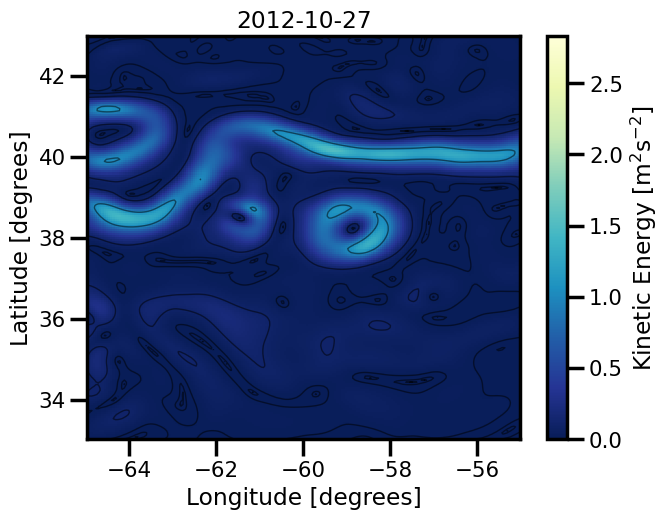

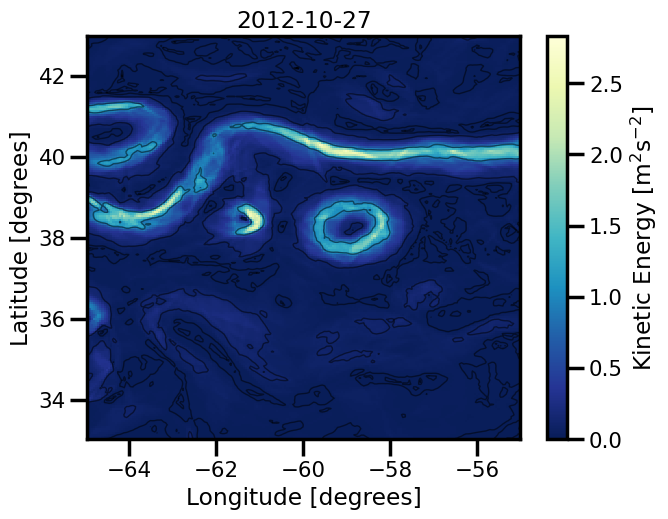

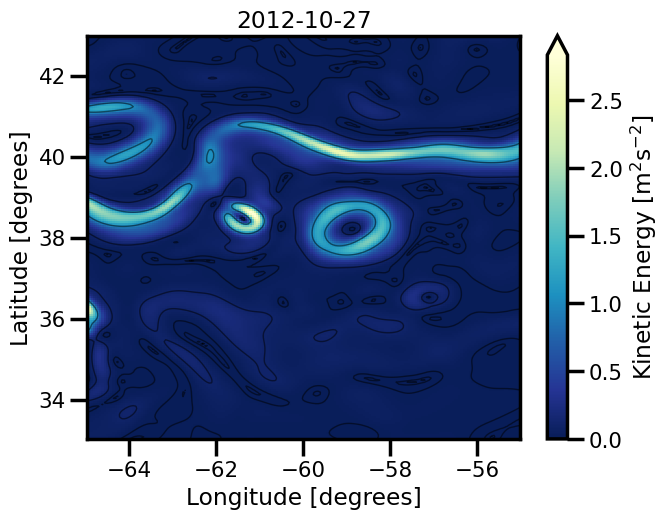

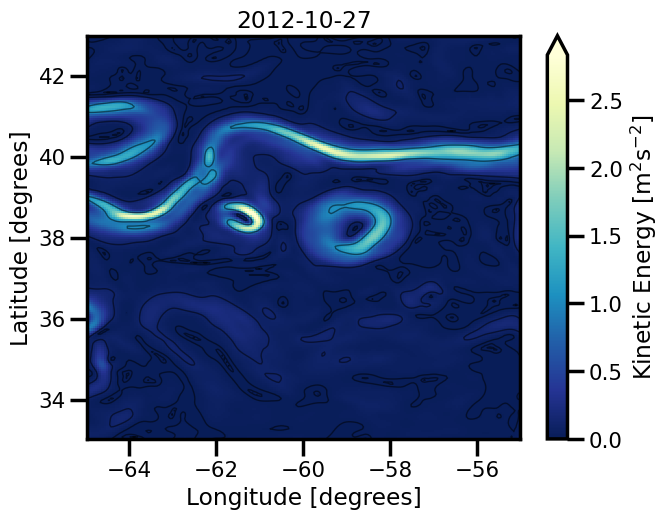

In [100]:
variable = "ke"
itime = "2012-10-27"
cmap = "YlGnBu_r"
robust = True

vmin = 0 #0.95 * ds_natl60[variable].sel(time=itime).min().pint.dequantify()#.quantile(0.05)
vmax = 1.05 * ds_natl60[variable].sel(time=itime).max().pint.dequantify()#.quantile(0.95)
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]

#NATL60
fig, ax = plot_ke_map(
    ds_natl60.sel(time=itime).pint.dequantify(), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_natl60_{experiment}_{itime}.png")
plt.show()

# DUACS
fig, ax = plot_ke_map(
    correct_labels(ds_duacs).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_duacs_{experiment}_{itime}.png")
plt.show()

# MIOST
fig, ax = plot_ke_map(
    ds_miost.sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_miost_{experiment}_{itime}.png")
plt.show()

# NERF - MLP
fig, ax = plot_ke_map(
    correct_labels(ds_nerf_mlp).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_mlp_{experiment}_{itime}.png")
plt.show()

# NERF - FFN
fig, ax = plot_ke_map(
    correct_labels(ds_nerf_ffn).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_ffn_{experiment}_{itime}.png")
plt.show()

# NERF - SIREN
fig, ax = plot_ke_map(
    correct_labels(ds_nerf_siren).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_siren_{experiment}_{itime}.png")
plt.show()

## Relative Vorticity

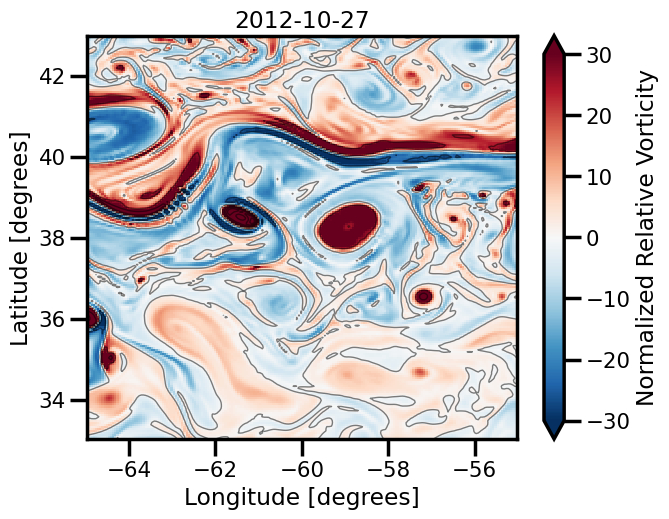

In [89]:
variable = "vort_r"
itime = "2012-10-27"
cmap = "RdBu_r"
robust = True

vmin = -30 #ds_natl60[variable].sel(time=itime).min().pint.dequantify().quantile(0.10)
vmax = 30 # ds_natl60[variable].sel(time=itime).max().pint.dequantify().quantile(0.90)
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]


#NATL60
fig, ax = plot_map(
    ds_natl60.sel(time=itime).pint.dequantify(), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_natl60_{experiment}_{itime}.png")
plt.show()

# DUACS
fig, ax = plot_map(
    correct_labels(ds_duacs).sel(time=itime), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_duacs_{experiment}_{itime}.png")
plt.close()

# MIOST
fig, ax = plot_map(
    correct_labels(ds_miost).sel(time=itime), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_miost_{experiment}_{itime}.png")
plt.close()

# NERF - MLP
fig, ax = plot_map(
    correct_labels(ds_nerf_mlp).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_mlp_{experiment}_{itime}.png")
plt.close()

# NERF - FFN
fig, ax = plot_map(
    correct_labels(ds_nerf_ffn).sel(time=itime), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_ffn_{experiment}_{itime}.png")
plt.close()

# NERF - SIREN
fig, ax = plot_map(
    correct_labels(ds_nerf_siren).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_siren_{experiment}_{itime}.png")
plt.close()

## Strain

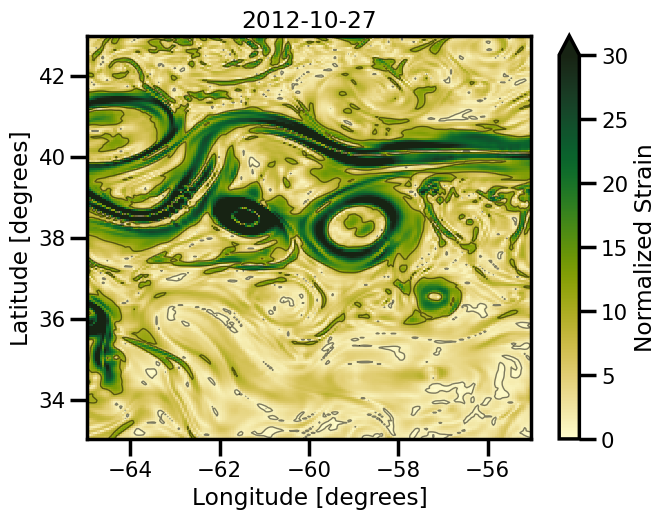

In [99]:
import cmocean as cmo

variable = "strain"
itime = "2012-10-27"
cmap = cmo.cm.speed
robust = True

vmin = 0#ds_natl60[variable].sel(time=itime).min().pint.dequantify().quantile(0.10)
vmax = 30 #ds_natl60[variable].sel(time=itime).max().pint.dequantify().quantile(0.90)
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]



#NATL60
fig, ax = plot_ke_map(
    ds_natl60.sel(time=itime).pint.dequantify(), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_natl60_{experiment}_{itime}.png")
plt.show()

# DUACS
fig, ax = plot_ke_map(
    correct_labels(ds_duacs).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_duacs_{experiment}_{itime}.png")
plt.close()

# MIOST
fig, ax = plot_ke_map(
    correct_labels(ds_miost).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_miost_{experiment}_{itime}.png")
plt.close()

# NERF - MLP
fig, ax = plot_ke_map(
    correct_labels(ds_nerf_mlp).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_mlp_{experiment}_{itime}.png")
plt.close()

# NERF - FFN
fig, ax = plot_map(
    correct_labels(ds_nerf_ffn).sel(time=itime), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_ffn_{experiment}_{itime}.png")
plt.close()

# NERF - SIREN
fig, ax = plot_map(
    correct_labels(ds_nerf_siren).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_siren_{experiment}_{itime}.png")
plt.close()